# Depth Evaluation Protocol for Deep GNNs

## Implementation Example

To reproduce the results of the paper, please define the experiment in the first cell and run this Notebook.

In [1]:
# Define experiment
DATASET = 'Cora'  # 'Cora', 'Citeseer', 'Pubmed', 'chameleon', 'squirrel', 'CoauthorPhysics', 'CoauthorCS', 'Actor', 'texas', 'cornell', 'wisconsin', 'ogbn-arxiv'
PARTITION = 0
HIDDEN_DIM = 16
N_LAYERS = 16
GNN = 'GCNInitRes'  # 'GCNInitRes', 'GCNII', 'G2', 'GATInitRes'

# GCN+InitRes/GCNII
ALPHA = 0.5

DROPOUT = 0.5


In [2]:
import os
from numpy import unique, isnan, array
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from data.loaders import load_dataset
from models import *
from utils import train_test_save
from cka import linear_CKA

# Export directories
results_dir = os.getcwd() + '/results/example/'
os.makedirs(results_dir, exist_ok=True)
figures_dir = os.getcwd() + '/figures/example/'
os.makedirs(figures_dir, exist_ok=True)

In [3]:
dataset = load_dataset(DATASET)
dataset.num_classes = len(unique(dataset.y))
print(dataset)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708, 10], val_mask=[2708, 10], test_mask=[2708, 10], num_classes=7)


In [4]:
# Create model
if GNN == 'GCNInitRes':
    model = GCNInitRes(in_channels=dataset.num_node_features, out_channels=dataset.num_classes, hidden_channels=HIDDEN_DIM,
                       n_layers=N_LAYERS, alpha=ALPHA, dropout=DROPOUT)
elif GNN == 'GCNII':
    model = GCNII(in_channels=dataset.num_node_features, out_channels=dataset.num_classes, hidden_channels=HIDDEN_DIM,
                  n_layers=N_LAYERS, alpha=ALPHA, dropout=DROPOUT)
elif GNN == 'G2':
    model = G2_GNN(nfeat=dataset.num_node_features, nhid=HIDDEN_DIM, nclass=dataset.num_classes, nlayers=N_LAYERS, drop=DROPOUT, drop_in=DROPOUT)

elif GNN == 'GATInitRes':
    model = GATInitRes(in_channels=dataset.num_node_features, out_channels=dataset.num_classes, hidden_channels=HIDDEN_DIM,
                       n_layers=N_LAYERS, alpha=ALPHA, dropout=DROPOUT)

print(model)

GCNInitRes(
  (pre_lin): Linear(in_features=1433, out_features=16, bias=True)
  (convs): ModuleList(
    (0): GCNInitResLayer((16), alpha=0.5
    (1): GCNInitResLayer((16), alpha=0.5
    (2): GCNInitResLayer((16), alpha=0.5
    (3): GCNInitResLayer((16), alpha=0.5
    (4): GCNInitResLayer((16), alpha=0.5
    (5): GCNInitResLayer((16), alpha=0.5
    (6): GCNInitResLayer((16), alpha=0.5
    (7): GCNInitResLayer((16), alpha=0.5
    (8): GCNInitResLayer((16), alpha=0.5
    (9): GCNInitResLayer((16), alpha=0.5
    (10): GCNInitResLayer((16), alpha=0.5
    (11): GCNInitResLayer((16), alpha=0.5
    (12): GCNInitResLayer((16), alpha=0.5
    (13): GCNInitResLayer((16), alpha=0.5
    (14): GCNInitResLayer((16), alpha=0.5
    (15): GCNInitResLayer((16), alpha=0.5
  )
  (post_lin): Linear(in_features=16, out_features=7, bias=True)
)


In [5]:
filename = '%s_part%i_%s_hid%s_l%i' % (DATASET, PARTITION, GNN + 'alpha%s' % int(ALPHA*100) if GNN in ['GCNInitRes', 'GCNII'] else GNN, HIDDEN_DIM, N_LAYERS)

# Train model; Save intermediate node representations
results_filepath = train_test_save(dataset, model, epochs=500, partition=PARTITION, save_as=results_dir + filename)

Val accuracy: 0.1457		Test accuracy: 0.1670
Training	Epoch 0		Train Loss: 1.9433		Val Loss: 1.9427		Train Acc: 0.1510
New best model | Test Accuracy 0.17
Val accuracy: 0.1457		Test accuracy: 0.1670
Training	Epoch 1		Train Loss: 1.9389		Val Loss: 1.9384		Train Acc: 0.1510
Val accuracy: 0.1457		Test accuracy: 0.1670
Training	Epoch 2		Train Loss: 1.9349		Val Loss: 1.9340		Train Acc: 0.1510
Val accuracy: 0.1457		Test accuracy: 0.1670
Training	Epoch 3		Train Loss: 1.9307		Val Loss: 1.9301		Train Acc: 0.1510
Val accuracy: 0.1457		Test accuracy: 0.1670
Training	Epoch 4		Train Loss: 1.9265		Val Loss: 1.9252		Train Acc: 0.1510
Val accuracy: 0.1457		Test accuracy: 0.1690
Training	Epoch 5		Train Loss: 1.9213		Val Loss: 1.9206		Train Acc: 0.1510
Val accuracy: 0.1457		Test accuracy: 0.1690
Training	Epoch 6		Train Loss: 1.9180		Val Loss: 1.9166		Train Acc: 0.1535
Val accuracy: 0.2186		Test accuracy: 0.2334
Training	Epoch 7		Train Loss: 1.9121		Val Loss: 1.9109		Train Acc: 0.2265
New best model | Tes

In [6]:
# Depth Evaluation Functions

def to_LogReg(df):
    layers = unique(df['layer'])
    h_sep = []
    for l in layers:
        filt = df[df.layer == l]
        feat_cols = [col for col in df.columns if 'feat' in col]
        X = filt.loc[:, feat_cols]
        y = filt.loc[:, 'y']
        logreg = LogisticRegression().fit(X, y)
        score = logreg.score(X, y)
        h_sep.extend([[l, score]])
    return array(h_sep)


def to_CKA(df):
    layers = unique(df['layer'])
    cka_df = pd.DataFrame(index=layers, columns=layers)
    feat_cols = [col for col in df.columns if 'feat' in col]

    for l in layers:
        print('CKA: %i / %i' % (l, max(layers)))
        filt1 = df[df.layer == l]
        X1 = filt1.reset_index().loc[:, feat_cols]
        if X1.shape[0] > 500:  # Randomly sample 500 examples, since CKA computation is inefficient
            X1 = X1.sample(500)
        for ll in layers:
            if isnan(cka_df.loc[ll, l]):
                filt2 = df[df.layer == ll]
                X2 = filt2.reset_index().loc[X1.index, feat_cols]
                cka_df.loc[l, ll] = linear_CKA(X1, X2)
                cka_df.loc[ll, l] = cka_df.loc[l, ll]
    return cka_df.astype(float)


In [7]:
# Read results_filepath
df = pd.read_csv(results_filepath)

# Compute layer-wise Logistic Regression and CKA
logreg = to_LogReg(df)
cka = to_CKA(df)

CKA: 0 / 16
CKA: 1 / 16
CKA: 2 / 16
CKA: 3 / 16
CKA: 4 / 16
CKA: 5 / 16
CKA: 6 / 16
CKA: 7 / 16
CKA: 8 / 16
CKA: 9 / 16
CKA: 10 / 16
CKA: 11 / 16
CKA: 12 / 16
CKA: 13 / 16
CKA: 14 / 16
CKA: 15 / 16
CKA: 16 / 16


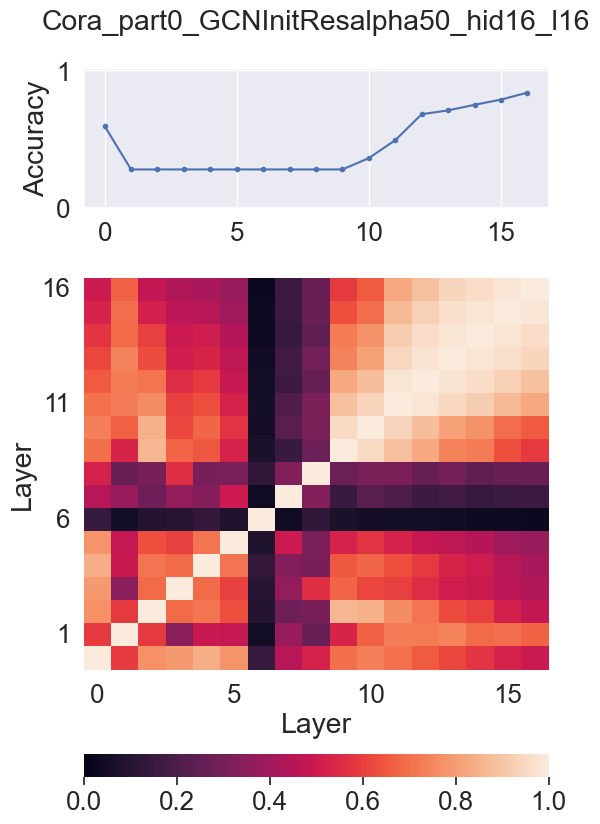

In [8]:
def figure(h_sep, cka, save_as=''):
    sns.set(font_scale=1.7)

    f, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 4]}, figsize=((6, 10)))

    axs[0].set_title(save_as.split('/')[-1] + '\n')

    axs[0].plot(h_sep[:, 0], h_sep[:, 1], '.-', label='alpha = ' + str(ALPHA))
    # axs[0].set_xlabel('Layer')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_ylim([0., 1.02])

    g = sns.heatmap(cka.sort_index(ascending=False), vmin=0., vmax=1.,
                    cmap=sns.color_palette("rocket", as_cmap=True),
                    xticklabels=5, yticklabels=5,
                        cbar=True,
                      #  cbar_ax=None if i_l else cbar_ax,
                        cbar_kws={"orientation": "horizontal"},
                        ax=axs[1])
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    g.set_xticklabels(g.get_xticklabels(), rotation=0)
    axs[1].set_xlabel('Layer')
    axs[1].set_ylabel('Layer')

    if save_as != '':
        f.savefig(save_as)

    plt.show()

    return

# Create and save figure
figure(logreg, cka, save_as=figures_dir + filename)